In [1]:
import os
import email
import re
import mailparser
import random
import spacy
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
from tld import get_tld
from time import strftime, strptime, time
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix, roc_curve, auc
from itertools import product
from sklearn.preprocessing import label_binarize

Set constants for directories, take a random sampling of the "ignore" email since there are so many (under sample)

In [2]:
IGNORE_DIR = '/Users/worshamn/Documents/emailProject/IgnoreFix'
INVESTIGATE_DIR = '/Users/worshamn/Documents/emailProject/InvestigateFix'
#https://stackoverflow.com/a/6482922
random.seed(2842)
ignore_sample_index = [ i for i in sorted(random.sample(range(len(os.listdir(IGNORE_DIR))), 400)) ]
ignore_sample = []
for i in ignore_sample_index:
    ignore_sample.append(os.listdir(IGNORE_DIR)[i])
input_dirs = {}
input_dirs[INVESTIGATE_DIR] = os.listdir(INVESTIGATE_DIR) 
input_dirs[IGNORE_DIR] = ignore_sample

In [3]:
len(input_dirs)

2

In [4]:
len(input_dirs[INVESTIGATE_DIR])

384

In [5]:
len(input_dirs[IGNORE_DIR])

400

Build function to extract text and features

In [6]:
def get_email_text(file):
    d = {}
    raw_message = email.message_from_file(file)
    mail = mailparser.parse_from_string(raw_message.as_string())
    d['subject'] = mail.subject
    d['subject_len'] = len(d['subject'])
    if raw_message.is_multipart():
        d['is_mulitpart'] = 1
    else:
        d['is_multipart'] = 0
    d['body'] = mail.text_plain
    if len(d['body']) > 0:
        d['mail_text'] = d['subject'] + ' ' + d['body'][0]
        d['body_len'] = len(d['body'][0])
        if len(d['body']) > 1:
            soup_html = BeautifulSoup(d['body'][1],'lxml')
            d['links'] = soup_html.find_all('a')
            d['num_link'] = len(d['links'])
            links = []
            d['masq_link'] = []
            d['masq_link_tld'] = []
            d['num_email_link'] = 0
            for link in d['links']:
                link_text = link.get_text().rstrip('\n')
                a_link = link.get('href')
                links.append(a_link)
                if 'unsubscribe' in link_text.lower():
                    d['has_unsubscribe_link'] = 1
                if a_link:    
                    if re.search('mailto:',a_link):
                        d['num_email_link'] += 1
                if a_link != link_text and \
                    'http' in link_text.lower() and \
                    not 'alt="http' in link_text.lower():
                        d['masq_link'].append(link)
                        d['masq_link_tld'].append(
                            get_tld(
                                a_link,
                                fix_protocol=True, 
                                fail_silently=True
                            )
                        )
            d['num_uniq_link'] = len(set(links))
            if d['num_link'] > d['num_uniq_link']:
                d['has_repeatlink'] = 1
            else:
                d['has_repeatlink'] = 0
            if len(d['masq_link']) == 0:
                d['masq_link'] = ''
                d['masq_link_tld'] = ''
                d['has_masq_link'] = 0
            else:    
                d['has_masq_link'] = 1
                d['num_masq_link'] = len(d['masq_link'])
    else:
        d['mail_text'] = d['subject']
        d['body_len'] = len(d['body'])
    url_query = '((?:https?|ftp)://[^\s/$.?#]+\.[^\s>]+)'
    d['url'] = re.findall(url_query,d['mail_text'])
    email_query = '([\w.]+@[\w.]+\.[\w.]{2,5})'
    d['email'] = re.findall(email_query,d['mail_text'])
    if d['url']:
        d['has_url'] = 1
        d['num_url'] = len(d['url'])
        d['num_uniq_url'] = len(set(d['url']))
        d['num_url_repeats'] = d['num_url'] - d['num_uniq_url']
        d['url_len'] = []
        d['url_tld'] = []
        for i in d['url']:
            d['url_len'].append(len(i))
            d['url_tld'].append(
                get_tld(i, fix_protocol=True, fail_silently=True)
            )
            d['uniq_url_tld'] = set(d['url_tld'])
    else:
        d['url'] = ''
        d['has_url'] = 0
        d['num_url'] = 0
        d['num_uniq_url'] = 0
        d['url_len'] = 0
        d['url_tld'] = 0
        d['uniq_url_tld'] = 0
        d['num_url_repeats'] = 0
    if d['email']:
        d['has_email'] = 1
        d['num_email_addr'] = len(d['email'])
        d['num_uniq_email'] = len(set(d['email']))
    else:
        d['email'] = ''
        d['has_email'] = 0
        d['num_email_addr'] = 0
        d['num_uniq_email'] = 0
    soup = BeautifulSoup(d['mail_text'],'lxml')
    try:
        d['mail_text'] = soup.get_text().encode(
            'utf-8',
            'ignore'
        ).decode('unicode_escape').replace('\n',' ').replace('\t',' ')
    except:
        d['mail_text'] = soup.get_text().replace('\n',' ').replace('\t',' ')
    d['reply_to'] = mail.reply_to
    for k,v in mail.headers.items():
        d[k] = v
    d['body'] = mail.body
    d['text_plain'] = mail.text_plain
    if mail.attachments:
        d['has_attachments'] = 1
        d['num_attachments'] = len(mail.attachments)
        for i in mail.attachments:
            try:
                d['attachment_filename'].append(i['filename'])
            except:
                d['attachment_filename'] = []
                d['attachment_filename'].append(i['filename'])
            try:
                d['attachment_content_type'].append(i['mail_content_type'])
            except:
                d['attachment_content_type'] = []
                d['attachment_content_type'].append(i['mail_content_type'])
    else:
        d['has_attachments'] = 0
    if re.search(tryGetKeyValue(d, 'Return-Path'),tryGetKeyValue(d, 'From')):
        d['return_path_match_from'] = 1
    else:
        d['return_path_match_from'] = 0
    tld_match = re.match(
            '[^@]+@([^>]+)>',
            tryGetKeyValue(d, 'From')
        )
    if tld_match:
        d['from_tld'] = get_tld(
            tld_match.group(1),
            fix_protocol=True, 
            fail_silently=True
        )
    if 'content="text/html' in d['body'].lower():
        d['has_html_content'] = 1
    else:
        d['has_html_content'] = 0
    if 'script type="text/javascript' in d['body'].lower():
        d['has_javascript'] = 1
    else:
        d['has_javascript'] = 0
    if 'img src="cid:' in d['body'].lower():
        d['has_inline_img'] = 1
    else:
        d['has_inline_img'] = 0
    if 'Content-type' in d:
        d['Content-type'] = re.match('([^;]+);',d['Content-type']).group(1)
    else:
        d['Content-type'] = None
    if 'Date' in d:
        #d['DOTW'] = strftime('%a',strptime(d['Date'],'%a, %d %b %Y %H:%M:%S %z'))
        d['DOTW'] = strftime('%w',strptime(d['Date'],'%a, %d %b %Y %H:%M:%S %z'))
        d['HOTD'] = strftime('%H',strptime(d['Date'],'%a, %d %b %Y %H:%M:%S %z'))
    if mail.has_defects:
        d['has_defects'] = 1
    else:
        d['has_defects'] = 0
    return d

Build function to set the target value based on the directory

In [7]:
def get_target(d):
    if d == IGNORE_DIR:
        return 'ignore'
    elif d == INVESTIGATE_DIR:
        return 'investigate'

Build function to extract value only if the key exists

In [8]:
def tryGetKeyValue(d, key, return_value=''):
  """Attempts to return value of key from dictionary
  """
  try:
    return d[key]
  except:
    return return_value

Create dataframe, iterate through directories and add email features

In [9]:
df = pd.DataFrame()
for d,v in input_dirs.items():
    for f in input_dirs[d]:
        print(d, f)
        with open(os.path.join(d,f),'r',encoding='utf-8', errors='ignore') as raw_mail:
            mail_dict = get_email_text(raw_mail)
            df = df.append(
                {
                    #'filename': f,
                    'text': mail_dict['mail_text'],
                    'target': get_target(d),
                    #'subject_len': mail_dict['subject_len'],
                    #'body_len': mail_dict['body_len'],
                    #'has_attachments': tryGetKeyValue(mail_dict, 'has_attachments',0),
                    #'num_attachments': tryGetKeyValue(mail_dict, 'num_attachments',0),
                    #'attachment_filename': tryGetKeyValue(mail_dict, 'attachment_filename'),
                    #'attachment_content_type': tryGetKeyValue(mail_dict, 'attachment_content_type'),
                    #'DKIM': tryGetKeyValue(mail_dict, 'X-BAEAI-DKIM'),
                    #'DMARC': tryGetKeyValue(mail_dict, 'X-BAEAI-DMARC'),
                    #'SPF': tryGetKeyValue(mail_dict, 'X-BAEAI-SPF'),
                    #'return_path_match_from': mail_dict['return_path_match_from'],
                    #'from_tld': tryGetKeyValue(mail_dict, 'from_tld'),
                    #'Content-type': mail_dict['Content-type'],
                    #'DOTW': tryGetKeyValue(mail_dict, 'DOTW'),
                    #'HOTD': tryGetKeyValue(mail_dict, 'HOTD'),
                    #'url': mail_dict['url'],
                    #'has_url': tryGetKeyValue(mail_dict, 'has_url',0),
                    #'num_url': tryGetKeyValue(mail_dict, 'num_url',0),
                    #'num_uniq_url': tryGetKeyValue(mail_dict, 'num_uniq_url',0),
                    #'email': tryGetKeyValue(mail_dict, 'email'),
                    #'has_email': tryGetKeyValue(mail_dict, 'has_email',0),
                    #'num_email_addr': tryGetKeyValue(mail_dict, 'num_email_addr',0),
                    #'num_uniq_email': tryGetKeyValue(mail_dict, 'num_uniq_email',0),
                    #'num_url_repeats': tryGetKeyValue(mail_dict, 'num_url_repeats',0),
                    #'url_len': mail_dict['url_len'],
                    #'url_tld': mail_dict['url_tld'],
                    #'uniq_url_tld': mail_dict['uniq_url_tld'],
                    #'has_html_content': tryGetKeyValue(mail_dict, 'has_html_content',0),
                    #'has_javascript': tryGetKeyValue(mail_dict, 'has_javascript',0),
                    #'has_inline_img': tryGetKeyValue(mail_dict, 'has_inline_img',0),
                    #'TAP-Score': tryGetKeyValue(mail_dict, 'X-USANET-TAP-Score',-1),
                    #'links': tryGetKeyValue(mail_dict, 'links'),
                    #'num_link': tryGetKeyValue(mail_dict, 'num_link',0),
                    #'num_uniq_link': tryGetKeyValue(mail_dict, 'num_uniq_link',0),
                    #'has_repeat_link': tryGetKeyValue(mail_dict, 'has_repeat_link',0),
                    #'masq_link': tryGetKeyValue(mail_dict, 'masq_link'),
                    #'has_masq_link': tryGetKeyValue(mail_dict, 'has_masq_link',0),
                    #'num_masq_link': tryGetKeyValue(mail_dict, 'num_masq_link',0),
                    #'masq_link_tld': tryGetKeyValue(mail_dict, 'masq_link_tld'),
                    #'is_multipart': tryGetKeyValue(mail_dict, 'is_mulitpart', 0),
                    #'has_defects': mail_dict['has_defects'],
                    #'num_email_link': tryGetKeyValue(mail_dict, 'num_email_link',0),
                    #'has_unsubscribe_link': tryGetKeyValue(mail_dict, 'has_unsubscribe_link', 0),
                }, 
                ignore_index=True
            )

/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- Goodchem Document.eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- Validate your Office 365 account.eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- INVOICE YAX-80-97157 Tom Jensen.eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- Invoice Problem 3.eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- Invoice from Karen Laman.eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- Case-637290015585-228.eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- 7 Past Due Invoices.eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- lmportant Message.eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- [Spam] Erinnerung an die Rechnungszahlung.eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- Re-[1].eml
/User

/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- _INV#00044901.eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- Delivery complete for parcel # 30726375.eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- Hope all your Christmas dreams come true!.eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- Payment issue 2.eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- UPS Ship Notification, Tracking Number 0RRN19486604712021.eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- Voice message from WIRELESS CALLER +1 718-963-4062).eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- Ren Hart used Dropbox to share a folder with you.eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- Paypal Receipt.eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- kantonena@mediastrom.gr has shared

/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- Your new Chase payment notice.eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- PAYMENT EAA-90-22623  .eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- ICBC Payment Remittance.eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- File shared 11-21-2017 on behalf of Kim Willoughby.eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- Wrong Invoice   Address.eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- Scanned Document - (Past due Invoice-083821.Pdf & Contract_Agreements.PDF).eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- [SPAM] New payment notification.eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- UPS Shipment Notification[2].eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- Division6.4 LLC share a document

/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- Information.eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- PayPal Reminder.eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- Tracking Number 5OX66928867835423.eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- INVOICE STATUS[1].eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- Explicit Content- For men over 30 ONLY!.eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- The amount of your's fee for confirmation.eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- Invoice Problem.eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- Business Opportunity.eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- Case-46199316665-157.eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- New Document.eml
/Users/

/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- C Fisher.eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- Your Legally Binding Contract document is ready for signature!.eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- [Spam] Invoice #00990339554.eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- Cheryl Dyer.eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- Incoming wireless message from +17323205192.eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- Coloradohandandarm ( Teusday 27, 2018).eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- Dylan Grant.eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- Delivery Status Notification.eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- Invoice PUJ #73722-AUL#YSML-2017 (21 Sep 17).eml
/Users/worshamn/Documents/emailProj

/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- Regulation Panel in Cape Town.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- [Webinar] InfoTrends on what’s next in cloud tech and managed print.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- [Spam] Jillian, here are 5 things you need to know before retiring.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- Support Denver Health Foundation on Colorado Gives Day.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- iPhone 8. Apple Watch Series 3. Pre-order now..eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- Best Practices in Rolling Forecasts.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- Microsoft(R) OneNote(R) Tips, Tricks and Best Practices - Register Today.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- [Spam] Cyber Week Special on Christmas Wristbands.eml
/Users

/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- Your BP is killing you..eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- eFax Corporate For Your Offices & Facilities.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- Corporate Performance Management eProgram.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- File Cabinet Document Attach - Claim Number E5L1046.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- WageWorks Email Enhancements.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- More Keynotes Announced – $1,100 Discount Expiring.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- Your ATD Membership.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- HexaCorp - Meeting Request..eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- Last Chance to RSVP! Private VIP Breakfast Presentation with dacadoo Found

/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- Hurricane Irma Statement.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- Webinar- How NAES Achieved Talent Pool Visibility.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- Pre-Sales Network Engineer.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- SharePoint- Inform and engage your employees.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- [Spam] Fwd- New Wind Standards for Metal Construction.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- 8th Circ. Upends Developer's $9M Win Against Fidelity.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- Includes- 5 Tools to Turn Your Targeting Around.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- Complimentary Gartner research to help guide your PPM strategy.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW-

/usr/local/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:96: DeprecationWarning: invalid escape sequence '\H'


/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- SharePoint Support Call.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- Save $1,100 thru Friday  Get In-Depth Knowledge.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- You need to lower your blood pressure.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- Last Chance- Labor Day Sale Ends Soon. Only $1 for 8 Weeks. Act Now..eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- FSA Store For Allergy Season.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- According to experts, wrinkles gets harder to treat as time goes by. .eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- Take a Six Minute Survey on Threat Intelligence from Dark Reading.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- {rp}, you are selected..eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] 

/usr/local/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:96: DeprecationWarning: invalid escape sequence '\#'


/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- How Big 5 Saved Big.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- Regulate your blood sugar without taking harmful medication..eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- Your Halloween Laugh from Churchill Claims.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- HI.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- Great webinars- Step by step.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- Ballast Water Treatment Systems Webcast- Navigating the challenges post-MEPC 71.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- Så skapar du en sociala medier-strategi – anmäl dig här.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- Samples of your favorite Beauty Brands free to try..eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- You have a new encryp

/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- Panic- Megyn Kelly's shocking admission puts NBC in panic mode.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- James Lafemina - Introduction Message.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- Pinnacol Assurance wellness clients.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- Update- Printing human organs - Progress.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- New Custom Grind Wedge, On the House!.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- Don’t Wait for a Resolution. Make a Change NOW!.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- [SQUADCO] SQuAD Board Special Election Ballot.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- ACTION REQUIRED - Final Step Pending- Confirm Your Email Address.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish A

/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- Jose Hernandez Sifuentes PPI.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- Quantzig's Sales Analytics  Try Us With A Pilot Project.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- Increase Revenue Flow with Every Payment Transaction.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- How 4,500 Worksites Are Getting Healthier Right Now.eml


Convert cells that are not recognized as a number or just to get rid of float

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 784 entries, 0 to 783
Data columns (total 2 columns):
target    784 non-null object
text      784 non-null object
dtypes: object(2)
memory usage: 12.3+ KB


In [11]:
df.text.iloc[50]

'Your recent payment notification to Oti Herrera Patricia Castillo,   This email is to inform you, that you have sent an instant payment of $3054.95 to Oti Herrera.  Allow up to 10 minutes for this transaction to post to your account.   Get your receipt here.     Chase. Unlike Your Bank    Warm Regards,  Daniel Anderson  Head of Bus Banking Customer Support     Please do not reply to this email address. You will not get a response.'

Create a function to clean the text

In [12]:
def clean_text(
    docs, 
    remove_urls=True,
    remove_emails=True,
    lemmatize=True,
    remove_stopwords=True, 
    custom_stopwords=None,
#     term_min_len=0,
):
    #only use parts of spaCy needed
    nlp = spacy.load('en', disable=['parser','ner','textcat'])
    #remove urls
    if remove_urls:
        print('remove URLS')
        docs = [
            re.sub('(?i)(?:www|https?)(?:://)?[^\s]+','',text)
            for text in docs
        ]
    #remove emails
    if remove_emails:
        print('remove email addresses')
        docs = [
            re.sub('(?i)[\w.]+@[\w.]+\.[\w.]{2,5}','',text)
            for text in docs
        ]
    #remove punct and digits
    print('removing punctuation and digits and change to lowercase')
    table = str.maketrans({key: None for key in string.punctuation + string.digits})
    clean_docs = [
#         str(d).lower().translate(table).replace('\n',' ')
        str(d).lower().translate(table)
        for d in docs
    ]
        
    #tokenize in spacy
    if lemmatize:
        print('spacy tokenization')
        nlp_docs = [nlp(d) for d in clean_docs]
        #lemmatization, words like I get changed into -PRON- so leave them alone
        if remove_stopwords:
            print('lemmatization and remove stopwords')
    #         stopwords_nltk = sorted(nltk.corpus.stopwords.words('english'))
            if custom_stopwords:
                custom_stopwords = set(custom_stopwords)
            else:
                custom_stopwords = []
            lemmatized_docs = [
                [
                    w.lemma_ 
                    for w in d
                    if (w.lemma_ != '-PRON-' and not w.is_stop and w.lemma_ not in custom_stopwords) 
                ]
                for d in nlp_docs
            ]
        else:
            print('lemmatization')
            lemmatized_docs = [
            [
                w.lemma_
                if w.lemma_ != '-PRON-'
                else w.lower_
                for w in d
            ]
            for d in nlp_docs
        ]
    if lemmatized_docs:
        clean_docs = lemmatized_docs

    # join tokens back into doc
    clean_docs = [
        ' '.join(l) 
        for l in clean_docs
    ]

    return clean_docs

Text the text cleaning

In [13]:
text = [
    "Validate your Office 365 account       You have a new message from the Microsoft Office team.  View Message ",
    "Invoice Problem Hello Jessica Rael,    Wasn’t lucky enough to get in touch with your the other day. Anyways, hopefully you can get back to me  about this invoice below.  Invoice Problem: http://hajnalattila.hu/Document/New-invoice-534677/    Thanks, Shannon Hazzard",
    "Not A law firms.",
    "test www.cnn.com. Candy land is my favorite workers comp www.google.com game",
    "LIBRARY: WWW.CLICWEB.ORG",
    "cschultz@ironwomancon.com sent you files via WeTransfer Get your files     Click 'Download images' to view images      cschultz@ironwomancon.com    sent you some files   1 file, 44.9 KB in total   Get your files        Download link  https://wetransfer.com/downloads/afe70c67af1520e3ea919cd4c21e958a20180521173535/b6d72890eb2c97f07608d369eec817a320180521173602/7a1e75    1 file  ironwomancon_invoice.html    To make sure our emails arrive, please add noreply@wetransfer.com   to your contacts  .  About WeTransfer     ・   Help     ・   Legal     ・   Report this transfer as spam  ",
]
clean_text(text, remove_urls=True)

remove URLS
remove email addresses
removing punctuation and digits and change to lowercase
spacy tokenization
lemmatization and remove stopwords


['validate office   account        new message microsoft office team   view message',
 'invoice problem hello jessica rael     not lucky touch day anyways hopefully   invoice   invoice problem      thank shannon hazzard',
 'law firm',
 'test   candy land favorite worker comp   game',
 'library',
 '  send file wetransfer file      click download image view image           send file     file   kb total    file         download link        file   ironwomanconinvoicehtml     sure email arrive add     contact     wetransfer      ・    help      ・    legal      ・    report transfer spam  ']

In [14]:
from time import time
t0 = time()
corpus = clean_text(
    df['text'], 
)
print("done in %0.3fs" % (time() - t0))

remove URLS
remove email addresses
removing punctuation and digits and change to lowercase
spacy tokenization
lemmatization and remove stopwords
done in 8.980s


In [15]:
df['cleaned_text'] = pd.Series(corpus).values

In [16]:
df.sample(10,random_state=123)

,target,text,cleaned_text
384,ignore,"Barbara.jones shrink your belly, 1lb day You d...",barbarajone shrink belly lb day not know tmz...
164,investigate,Payment to Transaction # 68M6WZF3N84J45K ...,payment transaction mwzfnjk hi amanda...
729,ignore,Bundle-ful Holiday Savings! Score incredible s...,bundleful holiday saving score incredible savi...
689,ignore,A 40% off that will melt away soon! â ð¥ C...,melt away soon â ð¥ come create video ho...
200,investigate,100.net; s 161025; h=x-gm-message-state:date...,net s hxgmmessagestatedatefromtomessageid...
776,ignore,Tomorrow: 7 Benefits of a Cloud Fax Service; A...,tomorrow benefit cloud fax service amazon ca...
476,ignore,Jim - quick question Jim - I would like to int...,jim quick question jim like introduce crow...
378,investigate,ShareFile Message From: Scott Houge ShareFile ...,sharefile message scott houge sharefile encryp...
565,ignore,Geopointe: #1 Rated Mapping Tool on Salesforce...,geopointe rat mapping tool salesforce hi bre...
392,ignore,Quality Pet Food Delivered Save $15 on on your...,quality pet food deliver save order cbfca...


Split the sample set into test and training sets

In [17]:
df_target = df['target']
df_feats = df['cleaned_text']
train_feats, test_feats, train_labels, test_labels = train_test_split(
    df_feats, 
    df_target, 
    test_size=0.20, 
    random_state=7350
)

In [18]:
train_feats.shape

(627,)

In [19]:
train_labels.value_counts()

ignore         318
investigate    309
Name: target, dtype: int64

#### TFIDF Creation

In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer
t0 = time()
vectorizer = TfidfVectorizer(
    ngram_range=(1,3),
    #max_df=0.9, 
    min_df=2,
    use_idf=False,
    norm=None,
    binary=True,
)
train_feats = vectorizer.fit_transform(train_feats.values.tolist())
test_feats = vectorizer.transform(test_feats.values.tolist()) 
print("done in %0.3fs" % (time() - t0))

done in 0.419s


In [21]:
train_feats.shape

(627, 8943)

In [22]:
test_feats.shape

(157, 8943)

Function to keep track of scoring and for printing results out

In [23]:
score_dict = {}
def scoring(score_dict,train_feats,train_labels,test_feats,test_labels,clf):
    if 'accuracy' not in score_dict:
        score_dict['accuracy'] = []
    if 'f1' not in score_dict:
        score_dict['f1'] = []
    if 'FN' not in score_dict:
        score_dict['FN'] = []
    clf_name = re.findall('(^[^\(]+)\(',str(clf))[0]
    try:
        already_seen = clf.score(train_feats, train_labels)
        accuracy = clf.score(test_feats, test_labels)
        pred = clf.predict(test_feats)
    except:
        already_seen = clf.score(train_feats.toarray(), train_labels)
        accuracy = clf.score(test_feats.toarray(), test_labels)
        pred = clf.predict(test_feats.toarray())
    f1 = f1_score(test_labels, pred, pos_label='investigate')
    cnf_matrix = confusion_matrix(test_labels, pred)
    FN = cnf_matrix[1][0]
    false_negative = cnf_matrix[1][0]
    score_dict['accuracy'].append((clf_name,accuracy))
    score_dict['f1'].append((clf_name,f1))
    score_dict['FN'].append((clf_name,false_negative))
    print(clf_name + ' Scores:\n')
    print('Accuracy of data already seen: %0.4f' % already_seen)
    print('Accuracy of data not seen: %0.4f' % accuracy)
    print('F1 score: %0.4f' % f1)
    print('False Negatives: %0d' % FN)
    return score_dict

#### SVM

In [24]:
from sklearn.svm import LinearSVC 
t0 = time()
svm_clf = LinearSVC(random_state=7350)
svm_clf.fit(train_feats, train_labels)
print("done in %0.3fs" % (time() - t0))
score_dict = scoring(score_dict,train_feats,train_labels,test_feats,test_labels,svm_clf)

done in 0.013s
LinearSVC Scores:

Accuracy of data already seen: 0.9984
Accuracy of data not seen: 0.9554
F1 score: 0.9548
False Negatives: 1


In [25]:
from sklearn.svm import SVC 
t0 = time()
svmr_clf = SVC(random_state=7350)
svmr_clf.fit(train_feats, train_labels)
print("done in %0.3fs" % (time() - t0))
score_dict = scoring(score_dict,train_feats,train_labels,test_feats,test_labels,svmr_clf)

done in 0.167s
SVC Scores:

Accuracy of data already seen: 0.5072
Accuracy of data not seen: 0.5223
F1 score: 0.0000
False Negatives: 75


/usr/local/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


#### Extra Trees Classifier

In [26]:
from sklearn.ensemble import ExtraTreesClassifier
t0 = time()
et_clf = ExtraTreesClassifier(n_jobs=-1,n_estimators=100,random_state=7350)
et_clf.fit(train_feats, train_labels)
print("done in %0.3fs" % (time() - t0))
score_dict = scoring(score_dict,train_feats,train_labels,test_feats,test_labels,et_clf)

done in 0.269s
ExtraTreesClassifier Scores:

Accuracy of data already seen: 0.9984
Accuracy of data not seen: 0.9554
F1 score: 0.9536
False Negatives: 3


Get Feature Importances

In [27]:
#http://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html
#https://stackoverflow.com/a/42429989
#https://stackoverflow.com/a/25219535
importances = et_clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in et_clf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]
features = vectorizer.get_feature_names()
print("Feature ranking:")
for f in range(25):
    print("%d. %s (%f)" % (f + 1, features[indices[f]], importances[indices[f]]))

Feature ranking:
1. unsubscribe (0.033818)
2. invoice (0.019966)
3. learn (0.013092)
4. not (0.011042)
5. time (0.010922)
6. register (0.010877)
7. future (0.009639)
8. email (0.009619)
9. start (0.008613)
10. today (0.008003)
11. include (0.007698)
12. free (0.007562)
13. work (0.007439)
14. help (0.007117)
15. need (0.006731)
16. like (0.006632)
17. solution (0.006617)
18. look (0.006533)
19. organization (0.006433)
20. try (0.006280)
21. right (0.006258)
22. product (0.006052)
23. payment (0.006030)
24. join (0.006017)
25. want (0.006010)


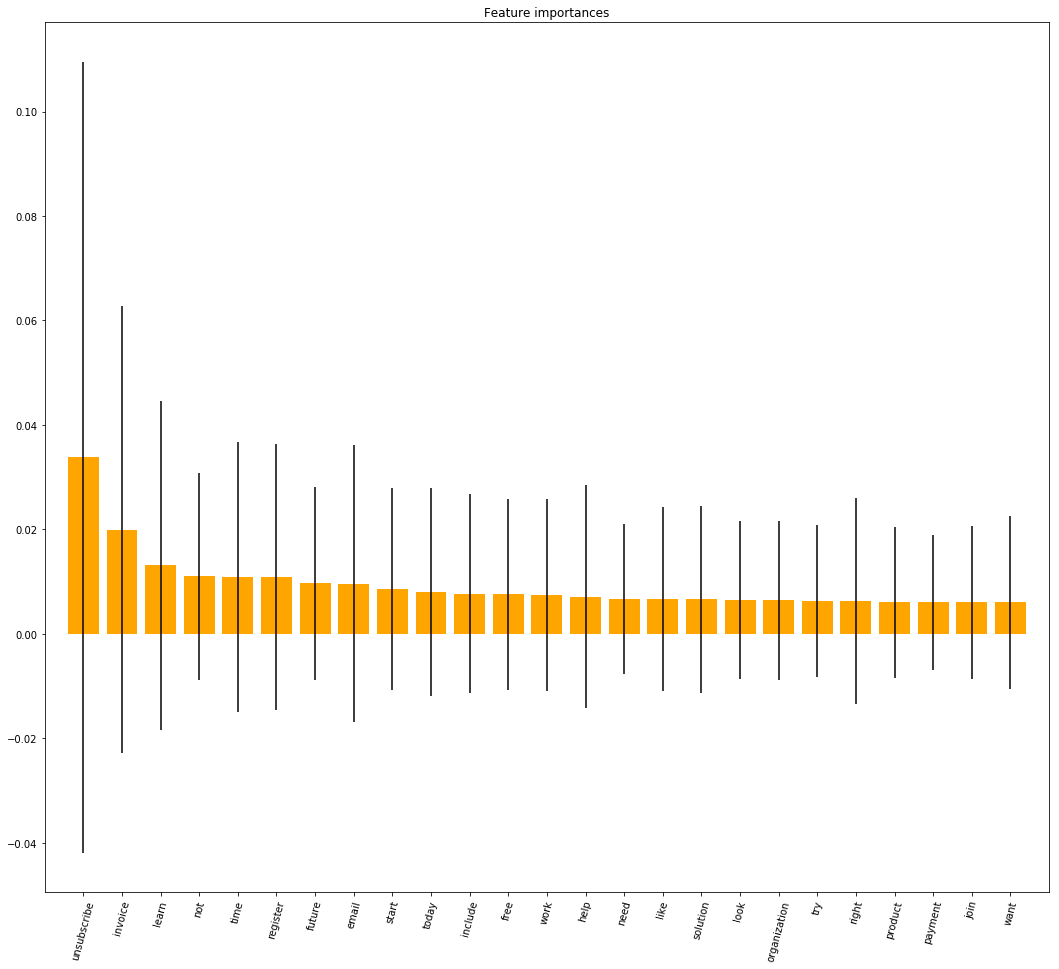

In [28]:
top_indices = indices[:25]
top_features = [features[i] for i in indices[:25]]
plt.figure(figsize=(18, 16))
plt.title("Feature importances")
plt.bar(range(25), importances[top_indices],color="orange", yerr=std[top_indices], align="center",)
plt.xticks(range(25), top_features, rotation=75)
plt.xlim([-1, 25])
plt.show()

#### Gradient Boost

In [29]:
from sklearn.ensemble import GradientBoostingClassifier
t0 = time()
gb_clf = GradientBoostingClassifier(n_estimators=100,random_state=7350)
gb_clf.fit(train_feats, train_labels)
print("done in %0.3fs" % (time() - t0))
score_dict = scoring(score_dict,train_feats,train_labels,test_feats,test_labels,gb_clf)

done in 0.661s
GradientBoostingClassifier Scores:

Accuracy of data already seen: 0.9888
Accuracy of data not seen: 0.9363
F1 score: 0.9351
False Negatives: 3


#### XGBoost

In [30]:
from xgboost import XGBClassifier
t0 = time()
xgb_clf = XGBClassifier(max_depth=5,random_state=7350,n_estimators=100,n_jobs=-1)
xgb_clf.fit(train_feats, train_labels)
print("done in %0.3fs" % (time() - t0))
score_dict = scoring(score_dict,train_feats,train_labels,test_feats,test_labels,xgb_clf)

done in 0.523s
XGBClassifier Scores:

Accuracy of data already seen: 0.9777
Accuracy of data not seen: 0.9490
F1 score: 0.9467
False Negatives: 4


/usr/local/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


#### Neural Net

In [31]:
from sklearn.neural_network import MLPClassifier
t0 = time()
nn_clf = MLPClassifier(max_iter=800)
nn_clf.fit(train_feats, train_labels)
print("done in %0.3fs" % (time() - t0))
score_dict = scoring(score_dict,train_feats,train_labels,test_feats,test_labels,nn_clf)

done in 7.566s
MLPClassifier Scores:

Accuracy of data already seen: 0.9984
Accuracy of data not seen: 0.9299
F1 score: 0.9299
False Negatives: 2


#### Naive Bayes

In [32]:
from sklearn.naive_bayes import MultinomialNB
t0 = time()
nb_clf = MultinomialNB(alpha=.001)
nb_clf.fit(train_feats, train_labels)
print("done in %0.3fs" % (time() - t0))
score_dict = scoring(score_dict,train_feats,train_labels,test_feats,test_labels,nb_clf)

done in 0.002s
MultinomialNB Scores:

Accuracy of data already seen: 0.9872
Accuracy of data not seen: 0.9363
F1 score: 0.9315
False Negatives: 7


In [33]:
from sklearn.naive_bayes import GaussianNB
t0 = time()
gnb_clf = GaussianNB()
gnb_clf.fit(train_feats.toarray(), train_labels)
print("done in %0.3fs" % (time() - t0))
score_dict = scoring(score_dict,train_feats,train_labels,test_feats,test_labels,gnb_clf)

done in 0.241s
GaussianNB Scores:

Accuracy of data already seen: 0.9952
Accuracy of data not seen: 0.9172
F1 score: 0.9091
False Negatives: 10


#### Random Forest

In [34]:
from sklearn.ensemble import RandomForestClassifier
t0 = time()
rf_clf = RandomForestClassifier(n_jobs=-1,n_estimators=100,random_state=7350)
rf_clf.fit(train_feats, train_labels)
print("done in %0.3fs" % (time() - t0))
score_dict = scoring(score_dict,train_feats,train_labels,test_feats,test_labels,rf_clf)

done in 0.273s
RandomForestClassifier Scores:

Accuracy of data already seen: 0.9984
Accuracy of data not seen: 0.9682
F1 score: 0.9673
False Negatives: 1


In [35]:
importances = et_clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in et_clf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]
features = vectorizer.get_feature_names()
print("Feature ranking:")
for f in range(25):
    print("%d. %s (%f)" % (f + 1, features[indices[f]], importances[indices[f]]))

Feature ranking:
1. unsubscribe (0.033818)
2. invoice (0.019966)
3. learn (0.013092)
4. not (0.011042)
5. time (0.010922)
6. register (0.010877)
7. future (0.009639)
8. email (0.009619)
9. start (0.008613)
10. today (0.008003)
11. include (0.007698)
12. free (0.007562)
13. work (0.007439)
14. help (0.007117)
15. need (0.006731)
16. like (0.006632)
17. solution (0.006617)
18. look (0.006533)
19. organization (0.006433)
20. try (0.006280)
21. right (0.006258)
22. product (0.006052)
23. payment (0.006030)
24. join (0.006017)
25. want (0.006010)


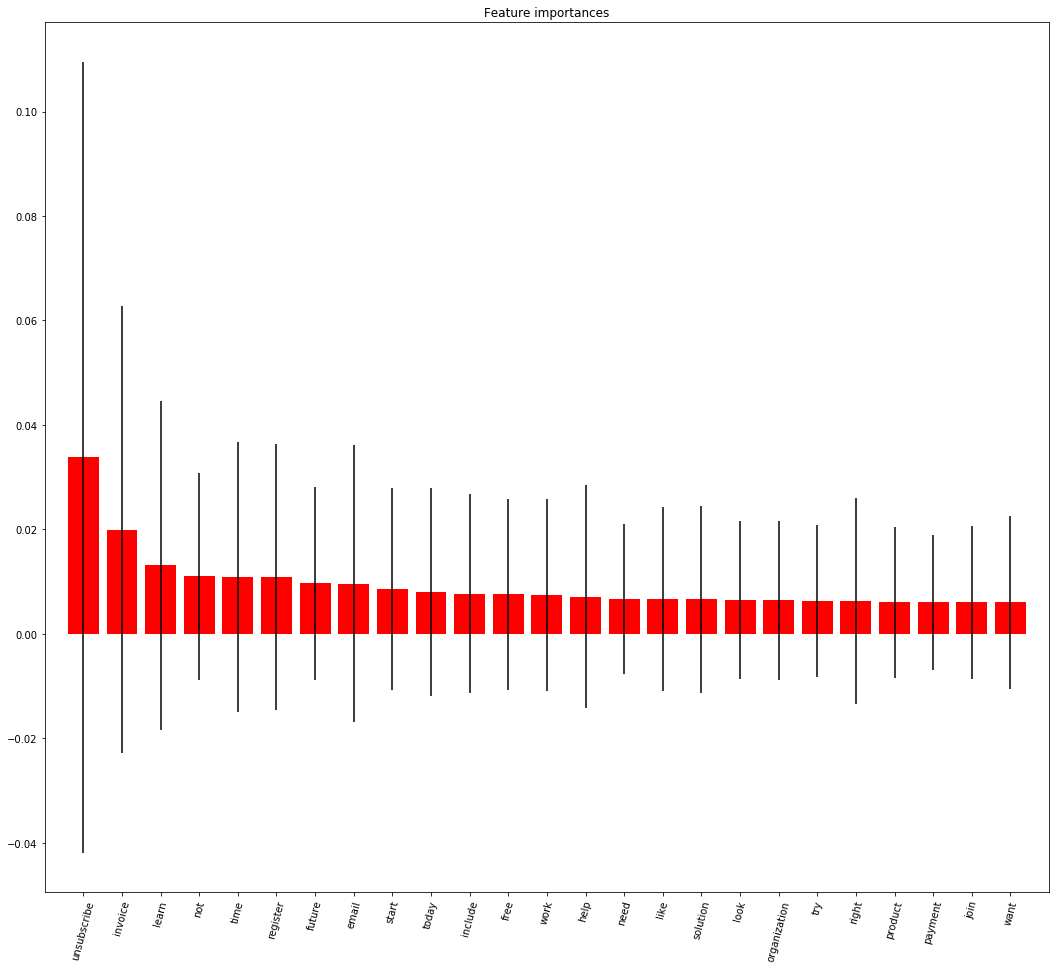

In [36]:
top_indices = indices[:25]
top_features = [features[i] for i in indices[:25]]
plt.figure(figsize=(18, 16))
plt.title("Feature importances")
plt.bar(range(25), importances[top_indices],color="red", yerr=std[top_indices], align="center",)
plt.xticks(range(25), top_features, rotation=75)
plt.xlim([-1, 25])
plt.show()

#### Nearest Neighbors

In [37]:
from sklearn.neighbors import KNeighborsClassifier
t0 = time()
knn_clf = KNeighborsClassifier(n_jobs=-1,leaf_size=100)
knn_clf.fit(train_feats, train_labels)
print("done in %0.3fs" % (time() - t0))
score_dict = scoring(score_dict,train_feats,train_labels,test_feats,test_labels,nn_clf)

done in 0.013s
MLPClassifier Scores:

Accuracy of data already seen: 0.9984
Accuracy of data not seen: 0.9299
F1 score: 0.9299
False Negatives: 2


#### NearestCentroid

In [38]:
from sklearn.neighbors import NearestCentroid
t0 = time()
nc_clf = NearestCentroid()
nc_clf.fit(train_feats, train_labels)
print("done in %0.3fs" % (time() - t0))
score_dict = scoring(score_dict,train_feats,train_labels,test_feats,test_labels,nc_clf)

done in 0.005s
NearestCentroid Scores:

Accuracy of data already seen: 0.8676
Accuracy of data not seen: 0.9045
F1 score: 0.9068
False Negatives: 2


#### AdaBoost

In [39]:
from sklearn.ensemble import AdaBoostClassifier
t0 = time()
ab_clf = AdaBoostClassifier(n_estimators=100,random_state=7350)
ab_clf.fit(train_feats, train_labels)
print("done in %0.3fs" % (time() - t0))
score_dict = scoring(score_dict,train_feats,train_labels,test_feats,test_labels,ab_clf)

done in 0.458s
AdaBoostClassifier Scores:

Accuracy of data already seen: 0.9984
Accuracy of data not seen: 0.9108
F1 score: 0.9079
False Negatives: 6


#### QuadraticDiscriminantAnalysis

In [40]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
t0 = time()
qda_clf = QuadraticDiscriminantAnalysis()
qda_clf.fit(train_feats.toarray(), train_labels)
print("done in %0.3fs" % (time() - t0))
score_dict = scoring(score_dict,train_feats,train_labels,test_feats,test_labels,qda_clf)

/usr/local/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


done in 0.912s
QuadraticDiscriminantAnalysis Scores:

Accuracy of data already seen: 0.9984
Accuracy of data not seen: 0.5350
F1 score: 0.0519
False Negatives: 73


#### GaussianProcessClassifier

In [41]:
from sklearn.gaussian_process import GaussianProcessClassifier
t0 = time()
gp_clf = GaussianProcessClassifier(random_state=7350)
gp_clf.fit(train_feats.toarray(), train_labels)
print("done in %0.3fs" % (time() - t0))
score_dict = scoring(score_dict,train_feats,train_labels,test_feats,test_labels,gp_clf)

done in 4.658s
GaussianProcessClassifier Scores:

Accuracy of data already seen: 0.9968
Accuracy of data not seen: 0.5669
F1 score: 0.6881
False Negatives: 0


#### Decision Tree

In [42]:
from sklearn.tree import DecisionTreeClassifier
t0 = time()
dt_clf = DecisionTreeClassifier(random_state=7350)
dt_clf.fit(train_feats, train_labels)
print("done in %0.3fs" % (time() - t0))
score_dict = scoring(score_dict,train_feats,train_labels,test_feats,test_labels,dt_clf)

done in 0.061s
DecisionTreeClassifier Scores:

Accuracy of data already seen: 0.9984
Accuracy of data not seen: 0.8662
F1 score: 0.8609
False Negatives: 10


#### LogisticRegression

In [43]:
from sklearn.linear_model import LogisticRegression
t0 = time()
lr_clf = LogisticRegression(random_state=7350)
lr_clf.fit(train_feats, train_labels)
print("done in %0.3fs" % (time() - t0))
score_dict = scoring(score_dict,train_feats,train_labels,test_feats,test_labels,lr_clf)

done in 0.026s
LogisticRegression Scores:

Accuracy of data already seen: 0.9936
Accuracy of data not seen: 0.9554
F1 score: 0.9548
False Negatives: 1


#### PassiveAggressiveClassifier

In [44]:
from sklearn.linear_model import PassiveAggressiveClassifier
t0 = time()
pa_clf = PassiveAggressiveClassifier(n_jobs=-1,random_state=7350)
pa_clf.fit(train_feats, train_labels)
print("done in %0.3fs" % (time() - t0))
score_dict = scoring(score_dict,train_feats,train_labels,test_feats,test_labels,pa_clf)

done in 0.010s
PassiveAggressiveClassifier Scores:

Accuracy of data already seen: 0.9984
Accuracy of data not seen: 0.9363
F1 score: 0.9359
False Negatives: 2


/usr/local/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


#### RidgeClassifier

In [45]:
from sklearn.linear_model import RidgeClassifier
t0 = time()
rd_clf = RidgeClassifier(random_state=7350)
rd_clf.fit(train_feats, train_labels)
print("done in %0.3fs" % (time() - t0))
score_dict = scoring(score_dict,train_feats,train_labels,test_feats,test_labels,rd_clf)

done in 0.295s
RidgeClassifier Scores:

Accuracy of data already seen: 0.9984
Accuracy of data not seen: 0.9427
F1 score: 0.9419
False Negatives: 2


#### SGDClassifier

In [46]:
from sklearn.linear_model import SGDClassifier
t0 = time()
sgd_clf = SGDClassifier(random_state=7350)
sgd_clf.fit(train_feats, train_labels)
print("done in %0.3fs" % (time() - t0))
score_dict = scoring(score_dict,train_feats,train_labels,test_feats,test_labels,sgd_clf)

done in 0.010s
SGDClassifier Scores:

Accuracy of data already seen: 0.9968
Accuracy of data not seen: 0.9299
F1 score: 0.9262
False Negatives: 6


/usr/local/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


#### CalibratedClassifierCV

In [47]:
from sklearn.calibration import CalibratedClassifierCV
t0 = time()
cc_clf = CalibratedClassifierCV()
cc_clf.fit(train_feats, train_labels)
print("done in %0.3fs" % (time() - t0))
score_dict = scoring(score_dict,train_feats,train_labels,test_feats,test_labels,cc_clf)

done in 0.034s
CalibratedClassifierCV Scores:

Accuracy of data already seen: 0.9984
Accuracy of data not seen: 0.9618
F1 score: 0.9610
False Negatives: 1


#### BaggingClassifier

In [48]:
from sklearn.ensemble import BaggingClassifier
t0 = time()
bg_clf = BaggingClassifier(n_jobs=-1,n_estimators=100,random_state=7350)
bg_clf.fit(train_feats, train_labels)
print("done in %0.3fs" % (time() - t0))
score_dict = scoring(score_dict,train_feats,train_labels,test_feats,test_labels,bg_clf)

done in 1.638s
BaggingClassifier Scores:

Accuracy of data already seen: 0.9984
Accuracy of data not seen: 0.9554
F1 score: 0.9530
False Negatives: 4


#### VotingClassifier

In [49]:
from sklearn.ensemble import VotingClassifier
t0 = time()
vt_clf = VotingClassifier(estimators=[
    ('nn',nn_clf),
#     ('nb',nb_clf),
#     ('et',et_clf),
#     ('sgd',sgd_clf),
    ('svm',svm_clf),
#     ('pa',pa_clf),
#     ('nc',nc_clf),
#     ('lr',lr_clf),
#     ('gp',gp_clf),
#     ('rd',rd_clf),
#     ('rf',rf_clf),
])
vt_clf.fit(train_feats, train_labels)
print("done in %0.3fs" % (time() - t0))

done in 7.621s


In [50]:
already_seen = vt_clf.score(train_feats, train_labels)
accuracy = vt_clf.score(test_feats, test_labels)
vt_pred = vt_clf.predict(test_feats)
f1 = f1_score(test_labels, vt_pred, pos_label='investigate')
cnf_matrix = confusion_matrix(test_labels, vt_pred)
FN = cnf_matrix[1][0]
false_negative = cnf_matrix[1][0]
print('VotingClassifier Scores:\n')
print('Accuracy of data already seen: %0.4f' % already_seen)
print('Accuracy of data not seen: %0.4f' % accuracy)
print('F1 score: %0.4f' % f1)
print('False Negatives: %0d' % FN)

VotingClassifier Scores:

Accuracy of data already seen: 0.9984
Accuracy of data not seen: 0.9490
F1 score: 0.9481
False Negatives: 2


/usr/local/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


#### Best Classifier Scores

In [51]:
print('Best Accuracy:\n')
for i in [
    '%s: %0.4f' % (k,v)
    for k,v in sorted(score_dict['accuracy'], key=lambda tup: tup[1], reverse=True)
    ][:3]:
    print(i)
print('\n\nBest F1 Score:\n')
for i in [
    '%s: %0.4f' % (k,v)
    for k,v in sorted(score_dict['f1'], key=lambda tup: tup[1], reverse=True)
    ][:3]:
    print(i)
print('\n\nBest False Negative Classifier:\n')
for i in [
    '%s: %i' % (k,v)
    for k,v in sorted(score_dict['FN'], key=lambda tup: tup[1])
    ][:3]:
    print(i)

Best Accuracy:

RandomForestClassifier: 0.9682
CalibratedClassifierCV: 0.9618
LinearSVC: 0.9554


Best F1 Score:

RandomForestClassifier: 0.9673
CalibratedClassifierCV: 0.9610
LinearSVC: 0.9548


Best False Negative Classifier:

GaussianProcessClassifier: 0
LinearSVC: 1
RandomForestClassifier: 1


#### Confusion Matrix and ROC curves of Top Algos

In [52]:
#http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    #fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [53]:
def display_conf_mat(clf,test_feats,test_labels):
    clf_name = re.findall('(^[^\(]+)\(',str(clf))[0]
    pred = clf.predict(test_feats)
    cnf_matrix = confusion_matrix(test_labels, pred)
    np.set_printoptions(precision=2)
    plt.figure(figsize=(5, 4))
    plot_confusion_matrix(cnf_matrix, classes=['ignore','investigate'],
                          title=clf_name + ' Confusion matrix')
    plt.show()   

In [54]:
#https://datamize.wordpress.com/2015/01/24/how-to-plot-a-roc-curve-in-scikit-learn/
#https://plot.ly/scikit-learn/plot-roc/
def plot_roc_curve(clf,test_feats,test_labels):
    clf_name = re.findall('(^[^\(]+)\(',str(clf))[0]
    # Binarize the output
    pred = clf.predict(test_feats)
    test_labels_bin = label_binarize(test_labels, classes=['ignore','investigate'])
    pred_bin = label_binarize(pred, classes=['ignore','investigate'])
    false_positive_rate, true_positive_rate, thresholds = roc_curve(test_labels_bin, pred_bin)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    plt.title(clf_name + ' Receiver Operating Characteristic')
    plt.plot(false_positive_rate, true_positive_rate, 'b',
        label='AUC = %0.2f'% roc_auc)
    plt.legend(loc='lower right')
    plt.plot([0,1],[0,1],'r--')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

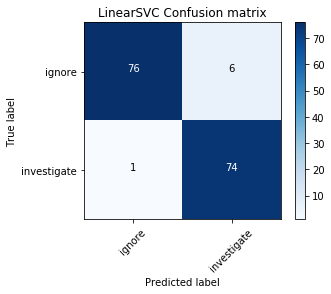

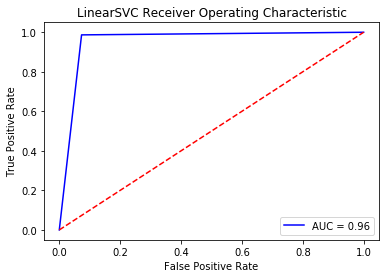

In [55]:
display_conf_mat(svm_clf,test_feats,test_labels)
plot_roc_curve(svm_clf,test_feats,test_labels)

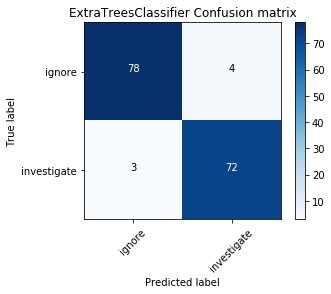

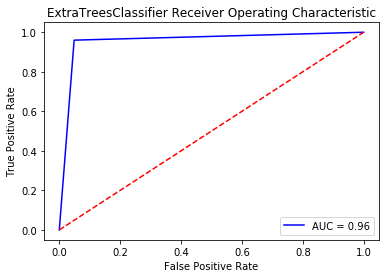

In [56]:
display_conf_mat(rf_clf,test_feats,test_labels)
plot_roc_curve(rf_clf,test_feats,test_labels)

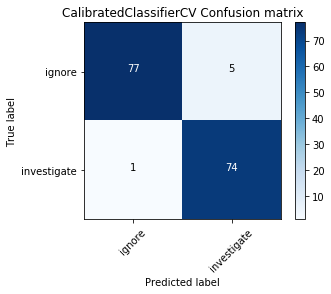

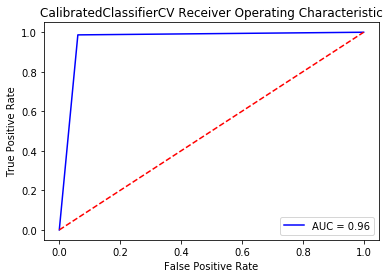

In [60]:
display_conf_mat(cc_clf,test_feats,test_labels)
plot_roc_curve(cc_clf,test_feats,test_labels)

/usr/local/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


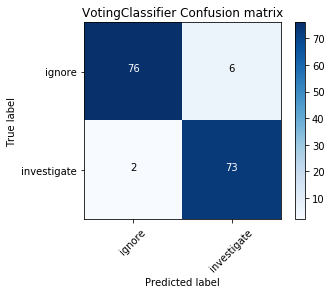

/usr/local/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


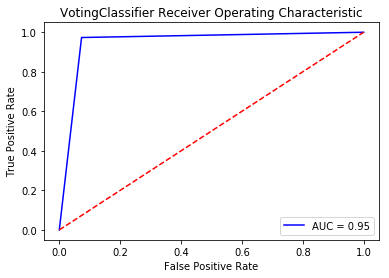

In [58]:
display_conf_mat(vt_clf,test_feats,test_labels)
plot_roc_curve(vt_clf,test_feats,test_labels)